### Can We Predict NBA Playoff Teams from Regular Season Statistics?

### Introduction

Every NBA season, teams play 82 regular-season games with hopes of earning a spot in the playoffs. But what determines whether a team qualifies for the postseason, beyond wins and losses? Is there a key offensive metric? or perhaps something on the defensive side? 

**In this project, we aim to explore whether a team's regular-season performance statistics can accurately predict playoff qualification**. Using historical data from NBA seasons between 2000 and 2023, we'll cover:

- Which stats are most associated with playoff success?
- Can we build a model that predicts whether a team will make the playoffs?

This project is built using several concepts covered in class - particularly general python data cleaning with pandas, correlation analysis, and logistic regression (both manually and using existing libraries).

### Data Overview

The dataset includes regular season summary statistics for each NBA team from 2000 through 2023, one row per team per season. The data was sourced from [Basketball Reference](https://www.basketball-reference.com/) and downloaded from Kaggle. It includes only regular season statistics (not playoff performance).

The goal is to use these stats to predict the `Playoff` label (1 = made playoffs, 0 = did not make playoffs) without relying on external projections or the already known result. Therefore, Playoff status is extracted from the original dataset by checking if a team name contains an asterisk `*`, which signifies a playoff team. This will give us a scenario where we evaluate playoff likelihood solely from observed performance.

Given that the Playoffs are often based on the teams with the most wins, and we are ultimately trying to understand if there is something outside of the the outcomes of the games that can help us predict playoff qualification, you'll notice in Step 3 that we start to exclude some variables from the analysis. 

#### Data Details

The table below includes all of the columns included in the dataset along with a brief description. Columns like **NA**, **NA.1**, and **NA.2** were present in the raw data but appear to be empty placeholders and will be removed in the cleaning step. 


| Column Name     | Description                                                                  |
|------------------|-----------------------------------------------------------------------------|
| **Rk**           | Rank of the team that season (based on performance)                         |
| **Team**         | Team name                                                                   |
| **Age**          | Average age of players on the roster                                        |
| **W** / **L**    | Wins and Losses during the regular season                                   |
| **PW** / **PL**  | Projected Wins and Losses (unknown model-based or statistical projection)   |
| **MOV**          | Margin of Victory per game                                                  |
| **SOS**          | Strength of Schedule                                                        |
| **SRS**          | Simple Rating System (MOV adjusted for SOS)                                 |
| **ORtg**         | Offensive Rating - points scored per 100 possessions                        |
| **DRtg**         | Defensive Rating - points allowed per 100 possessions                       |
| **NRtg**         | Net Rating = ORtg - DRtg (overall team strength)                            |
| **Pace**         | Possessions per 48 minutes (team tempo)                                     |
| **FTr**          | Free Throw Rate (FT attempts per FG attempt)                                |
| **3PAr**         | 3-Point Attempt Rate (3PA / FGA)                                            |
| **TS%**          | True Shooting % (adjusted for FG, 3P, FT efficiency)                        |
| **eFG%**         | Effective FG % on offense                                                   |
| **TOV%**         | Turnover % on offense                                                       |
| **ORB%**         | Offensive Rebound Rate                                                      |
| **FT/FGA**       | Free Throws per Field Goal Attempt (offense)                                |
| **eFG%.1**       | Opponent Effective FG % (defensive stat)                                    |
| **TOV%.1**       | Turnover % forced on defense                                                |
| **DRB%**         | Defensive Rebound Rate                                                      |
| **FT/FGA.1**     | Opponent Free Throws per Field Goal Attempt (defensive FT rate)             |
| **Arena**        | Team’s home arena                                                           |
| **Attend.**      | Total attendance at home games                                              |
| **Attend./G**    | Average attendance per home game                                            |
| **Year**         | Season year (column renamed from "2000" in header)                          |


> **Note:**  
> The dataset includes **PW** (Projected Wins) and **PL** (Projected Losses), however these values were **not used in the prediction model**.
> They are included only for reference.
> Including the projected data as inputs when trying to predict actual playoff appearance would introduce data leakage, as we don't know how these projections were created. 

### Step 1: Data Cleaning

Before we can analyze or model the data, we need to ensure it’s clean. 

#### Dataset Structure

The dataset includes regular season statistics for all NBA teams from 2000–2023. However:
- The first row contains some unclear / offset column labels.
- The second row contains the true column headers, but includes duplicate names like **eFG%** and **TOV%**, which appear for both offense and defense - we will relabel those accordingly to avoid confusion. 
- There are also placeholder columns such as NA which need to be removed.

#### Strategy

1. Import necessary libraries for data handling and visualization: pandas, numpy, matplotlib.pyplot, and seaborn, skylearn.

2. Load the dataset using the second row as the actual header (header=1).

3. Remove repeated header rows in the data (where **'Rk'** == **'Rk'**). For each season, the header rows were included as a row.

4. Rename ambiguous columns to clarify whether they refer to offense or defense (see table below for full details).

5. Drop placeholder unncessary columns such as NA.

6. Clean team names by removing asterisks `*`, which indicate playoff teams. These will be used later to generate the `Playoff` label.

7. Remove commas from string-based numeric columns like `Attend` and `Attend_per_Game`, then convert them to numeric data type.

8. Calculate `Attend_per_Game` for seasons like 2000 where it’s missing using:  `Attend / (W+L)`. Ensure that `W` and `L` are numeric before the calculation.

9. Convert all remaining numeric columns to numeric values for clean modeling.

10. Create a `WinPct` (win percentage) column as an indicator of team success, using the formula: `W / (W + L)`.

11. Drop any rows missing `WinPct`, and reset the index.


#### Renamed Columns for Clarity

| Original Column Name | Renamed To         | Description                                           |
|----------------------|--------------------|-------------------------------------------------------|
| `eFG%`               | `eFG_Offense%`     | Effective Field Goal % on offense                     |
| `TOV%`               | `TOV_Offense%`     | Turnover % on offense                                 |
| `FT/FGA`             | `FT/FGA_Offense`   | Free Throws per Field Goal Attempt on offense         |
| `eFG%.1`             | `eFG%_Defense`     | Effective FG % allowed (defensive stat)               |
| `TOV%.1`             | `TOV%_Defense`     | Turnover % forced on defense                          |
| `FT/FGA.1`           | `FT/FGA_Defense`   | Free Throws per Field Goal Attempt allowed (defense)  |
| `Attend.`            | `Attend`           | Total home game attendance                            |
| `Attend./G`          | `Attend_per_Game`  | Average attendance per home game                      |
| `2000`               | `Year`             | Season year                                           |


### Step 1: Data Cleaning --- Code

In [1]:
# 1. Import all libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


print("Succesfully loaded all libraries.")

Succesfully loaded all libraries.


In [2]:
# 2. Load the dataset using the second row as the actual header
df = pd.read_csv("/Users/samanthashuford/Desktop/advanced_stats_total.csv", header = 1)

# 3. Remove repeated header rows in the data
df = df[df['Rk'] != 'Rk'].copy()

# 4. Rename ambiguous / duplicated column names for better clarity
rename_columns = {
    'eFG%': 'eFG_Offense%',
    'TOV%': 'TOV_Offense%',
    'FT/FGA': 'FT/FGA_Offense',
    'eFG%.1': 'eFG_Defense%',
    'TOV%.1': 'TOV_Defense%',
    'FT/FGA.1': 'FT/FGA_Defense',
    'Attend.': 'Attend',
    'Attend./G': 'Attend_per_Game',
    '2000': 'Year'
}

df.rename(columns=rename_columns, inplace=True)

# 5. Drop placeholder or unnecessary columns
drop_cols = ['1', 'NA', 'NA.1', 'NA.2', '...29', '...30', '...31']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# 6. Clean up team names (remove asterisk indicating playoff teams) - we want to treat Lakers* and Lakers equally
df['Team'] = df['Team'].str.replace('*', '', regex=False).str.strip()

# 7. Remove commas from attendance columns and convert to numeric
if 'Attend' in df.columns:
    df['Attend'] = df['Attend'].str.replace(',', '', regex=False)
    df['Attend'] = pd.to_numeric(df['Attend'], errors='coerce')

if 'Attend_per_Game' in df.columns:
    df['Attend_per_Game'] = df['Attend_per_Game'].str.replace(',', '', regex=False)
    df['Attend_per_Game'] = pd.to_numeric(df['Attend_per_Game'], errors='coerce')

# 8. Calculate Attend_Per_Game (not included for Year 2000 even though we can calculate it)

# Convert W and L to numeric before creating the Attend_Per_Game calculation
df['W'] = pd.to_numeric(df['W'], errors='coerce')
df['L'] = pd.to_numeric(df['L'], errors='coerce')

if 'Attend' in df.columns and 'Attend_per_Game' in df.columns:
    missing_apg = df['Attend_per_Game'].isna() & df['Attend'].notna()
    df.loc[missing_apg, 'Attend_per_Game'] = df.loc[missing_apg, 'Attend'] / (df.loc[missing_apg, 'W'] + df.loc[missing_apg, 'L'])

# Round the calculated Attend_per_Game to zero decimals
df['Attend_per_Game'] = df['Attend_per_Game'].round()

# 9. Convert all other numeric columns (except team and arena)
for col in df.columns:
    if col not in ['Team', 'Arena', 'Attend', 'Attend_per_Game']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 10. Create a win percentage (WinPct) column
df['WinPct%'] = df['W'] / (df['W'] + df['L'])

# 11. For cleanliness, make all percentage column an actual percentage
cols_to_percent = ['TS%', 'eFG_Offense%','eFG_Defense%','WinPct%']

for col in cols_to_percent:
    df[col] = round(((df[col]) * 100),1)

# 11. Drop rows where there is no WinPct
df.dropna(subset=['WinPct%'], inplace=True)

# 11. Reset the index
df.reset_index(drop=True, inplace=True)

# Review the cleaned dataframe
pd.set_option('display.max_columns', None)
df.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG_Offense%,TOV_Offense%,ORB%,FT/FGA_Offense,eFG_Defense%,TOV_Defense%,DRB%,FT/FGA_Defense,Arena,Attend,Attend_per_Game,Year,WinPct%
0,1.0,Los Angeles Lakers,29.2,67.0,15.0,64,18,8.55,-0.14,8.41,107.3,98.2,9.1,93.3,0.346,0.153,52.5,48.4,12.7,30.6,0.241,44.3,13.4,73.1,0.222,STAPLES Center,771420.0,9408.0,2000,81.7
1,2.0,Portland Trail Blazers,29.6,59.0,23.0,59,23,6.40,-0.04,6.36,107.9,100.8,7.1,89.9,0.316,0.175,54.6,50.1,14.5,30.3,0.240,46.1,13.8,72.4,0.217,Rose Garden Arena,835078.0,10184.0,2000,72.0
2,3.0,San Antonio Spurs,30.9,53.0,29.0,58,24,5.94,-0.02,5.92,105.0,98.6,6.4,90.8,0.346,0.138,53.5,48.8,14.3,27.8,0.258,45.1,13.5,73.0,0.188,Alamodome,884450.0,10786.0,2000,64.6
3,4.0,Phoenix Suns,28.6,53.0,29.0,56,26,5.22,0.02,5.24,104.6,99.0,5.6,94.0,0.286,0.184,53.2,49.1,15.2,29.3,0.217,45.4,15.7,70.5,0.245,America West Arena,773115.0,9428.0,2000,64.6
4,5.0,Utah Jazz,31.5,55.0,27.0,54,28,4.46,0.05,4.52,107.3,102.3,5.0,89.6,0.337,0.134,54.0,49.0,14.3,29.5,0.260,47.7,15.0,73.2,0.256,Delta Center,801268.0,9772.0,2000,67.1


In [3]:
# Review the cleaned dataframe, data types
df.dtypes

Rk                 float64
Team                object
Age                float64
W                  float64
L                  float64
PW                   int64
PL                   int64
MOV                float64
SOS                float64
SRS                float64
ORtg               float64
DRtg               float64
NRtg               float64
Pace               float64
FTr                float64
3PAr               float64
TS%                float64
eFG_Offense%       float64
TOV_Offense%       float64
ORB%               float64
FT/FGA_Offense     float64
eFG_Defense%       float64
TOV_Defense%       float64
DRB%               float64
FT/FGA_Defense     float64
Arena               object
Attend             float64
Attend_per_Game    float64
Year                 int64
WinPct%            float64
dtype: object

### Step 2: Adding Playoff Labels

In this step, we add a new column to the cleaned dataframe that determines whether a team made the playoffs (`Playoff` = 1) or not (`Playoff` = 0). This is based on the actual result and if that team actually made the playoffs that year or not. This will help us build the models and eventually determine the accuracy. 

#### Strategy

1. Load the original (uncleaned) dataset, which still includes the asterisks (`*`) to indicate if the team made the playoffs. The asteriks were removed earlier during step 1 for cleaning, but now we’ll use them to make the `Playoff` column.

2. Create the `Playoff` column:
   - If a team name contains an asterisk `*`, it's labeled as `1` (made the playoffs).
   - If a team name does not contain an asterik, it’s labeled as `0` (did not make the playofffs).

3. Clean the team name again to match the cleaned version in `df`, ensuring we can merge the `Playoff` data back into the main (cleaned) dataframe.  

4. Merge the `Playoff` label into the cleaned dataframe using both `Team` and `Year` as keys.

5. Fill in any missing playoff labels as `0` - assuming if they didn't have an asterik then they did not make the playoffs.

This step gives us the outcome variable we’ll use for classification modeling and clustering analysis in later sections.


### Step 2: Adding Playoff Labels --- Code

In [4]:
# 1. Load the original (uncleaned) data, starting at the second row. This still includes the asterisks (*) indicating playoff teams
raw_df = pd.read_csv("/Users/samanthashuford/Desktop/advanced_stats_total.csv").iloc[1:].copy()

# 2. Create a binary column 'Playoff' based on presence of asterisk in the team name. Teams with '*' made the playoffs (1) & did not make the playoffs (0)
raw_df['Playoff'] = raw_df['Team'].str.contains('\\*', regex = True).astype(int)

# 3. Remove the asterisk from team names so they match the cleaned dataframe and so we can merge it back to the cleaned data
raw_df['Team'] = raw_df['Team'].str.replace('*', '', regex = False).str.strip()

# 4. Merge the playoff flag back into the cleaned data using 'Team' and 'Year' as keys
df = df.merge(raw_df[['Team', 'Year', 'Playoff']], on=['Team', 'Year'], how = 'left')

# 5. Fill any missing values in 'Playoff' with 0 (assumming if they didn't have an asterisk then did not make the playoffs)
df['Playoff'] = df['Playoff'].fillna(0).astype(int)

# Review the updated dataframe
df.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG_Offense%,TOV_Offense%,ORB%,FT/FGA_Offense,eFG_Defense%,TOV_Defense%,DRB%,FT/FGA_Defense,Arena,Attend,Attend_per_Game,Year,WinPct%,Playoff
0,1.0,Los Angeles Lakers,29.2,67.0,15.0,64,18,8.55,-0.14,8.41,107.3,98.2,9.1,93.3,0.346,0.153,52.5,48.4,12.7,30.6,0.241,44.3,13.4,73.1,0.222,STAPLES Center,771420.0,9408.0,2000,81.7,1
1,2.0,Portland Trail Blazers,29.6,59.0,23.0,59,23,6.40,-0.04,6.36,107.9,100.8,7.1,89.9,0.316,0.175,54.6,50.1,14.5,30.3,0.240,46.1,13.8,72.4,0.217,Rose Garden Arena,835078.0,10184.0,2000,72.0,1
2,3.0,San Antonio Spurs,30.9,53.0,29.0,58,24,5.94,-0.02,5.92,105.0,98.6,6.4,90.8,0.346,0.138,53.5,48.8,14.3,27.8,0.258,45.1,13.5,73.0,0.188,Alamodome,884450.0,10786.0,2000,64.6,1
3,4.0,Phoenix Suns,28.6,53.0,29.0,56,26,5.22,0.02,5.24,104.6,99.0,5.6,94.0,0.286,0.184,53.2,49.1,15.2,29.3,0.217,45.4,15.7,70.5,0.245,America West Arena,773115.0,9428.0,2000,64.6,1
4,5.0,Utah Jazz,31.5,55.0,27.0,54,28,4.46,0.05,4.52,107.3,102.3,5.0,89.6,0.337,0.134,54.0,49.0,14.3,29.5,0.260,47.7,15.0,73.2,0.256,Delta Center,801268.0,9772.0,2000,67.1,1


### Step 3: Exploratory Data Analysis

In this step, we begin to explore the data to identify patterns, relationships, and potential predictors of playoff success.

#### Strategy

1. Correlation Heatmap:
   We begin by generating a correlation heatmap of all numeric variables (excluding outcome variables like `PW`, `PL`, and `Rk`).  
   This helps us:
   - Identify strongly correlated variables 
   - Identify metrics that move together  (i.e. if one variable increases then does another one increase or decrease)

>   Heatmap Color Legend:
>   - **Dark Blue** = strong positive correlation (when one variable increases, the other tends to increase)  
>   - **Dark Red** = strong negative correlation (when one variable increases, the other tends to decrease)  
>   - **Light Colors / White** = weak or no correlation  

2. Bar Chart: Variables Correlated with Playoff Status:
   Next, we focus in on the target outcome (making the playoffs) and review how each numeric variable correlates with `Playoff`.  
   We visualize the **top 10 positive** and **top 10 negative** correlations in a horizontal bar chart.

>   Bar Chart Color Legend:
>   - **Positive correlation** = higher values of the varbiales are associated with playoff teams  
>   - **Negative correlation** = higher values are associated with non-playoff teams  

   This gives us a starting point for identifying which variables may be worth including in future models.

### Step 3: Correlation Heatmap --- Code

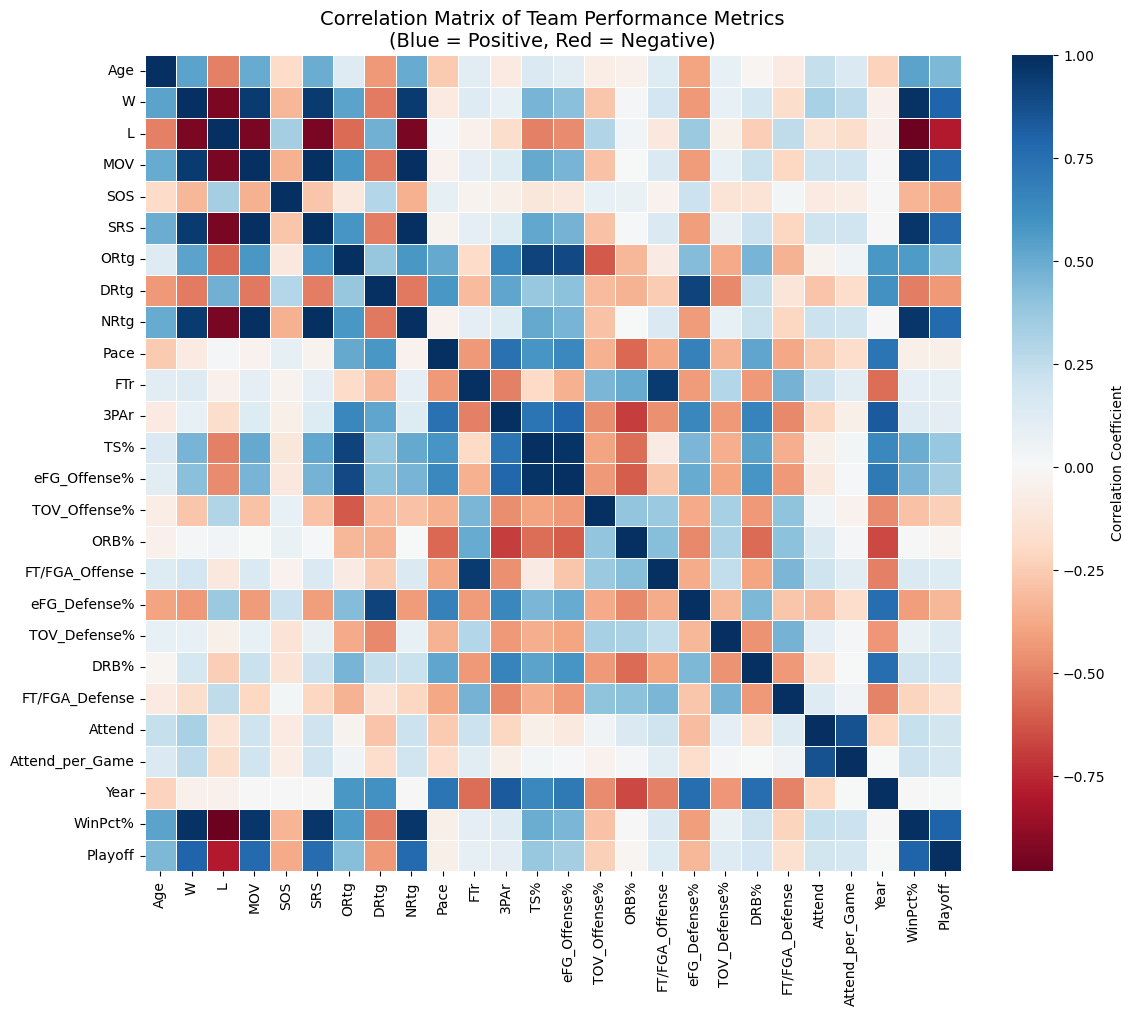

In [5]:
# List of columns to exclude from the correlation matrix
exclude_cols = ['PW', 'PL', 'Rk']

# Create a subset of the dataframe for correlation
df_heatmap = df.drop(columns=[col for col in exclude_cols if col in df.columns])

# Plot the heatmap
plt.figure(figsize = (12, 10))
sns.heatmap(
    df_heatmap.corr(numeric_only = True), 
    cmap = 'RdBu',
    annot = False,
    center = 0, 
    square = True, 
    linewidths = 0.5,
    cbar_kws = {'label': 'Correlation Coefficient'}
)
plt.title("Correlation Matrix of Team Performance Metrics\n(Blue = Positive, Red = Negative)", fontsize=14)
plt.tight_layout()
plt.show()

#### What can we takeaway from the Correlation Heat Map? 

- As expected, `W` (Wins) and `L` (Losses) are strongly negatively correlated. As Wins increase, Lossses decrease.
- `Playoff` is strongly positively correlated with the following: `MOV`,`NRtg`,`SRS` and `WinPct%`.
- `Playoff` is positively correlated with the following: `Age`, `ORtg`, `TS`, and `eFG_Offense%`.
  - `Age` is interesting, potentially indicating that teams with an older roster could perform better, perhaps for benefits like maturity, experience, and game knowledge.
--- 
- `Playoff` is strongly negatively correlated with the following: `L`.
- `Playoff` is negatively correlated with the following: `SOS`, `DRtg`, and `eFG%_Defense`.
  - `DRtg` and `eFG%_Defense` are both very interesting. A low `DRtg` and `eFG%_Defense` indicate better defensive performance. As the popular saying goes "Offense wins games, and Defense wins championships"... these negatively correlated relationships indicate that the better the defense the higher the chance of making the playoffs. 
--- 
- For my NBA nerds, a few other interesting finds are listed below:
  - As the `Year` increases, the `3PAr` increases, a known phenomenon in the game as 3-pointers have become more and more ingrained in the game over the last ~20 years.
  - As the `Year` increases, the `ORB%` decreases, a common criticism of the league is that it's all offense and no defense, and the decline in offensive rebounding could be a solid point for that argument.

### Step 3 - Bar Chart: Variables Correlated with Playoff Status --- Code

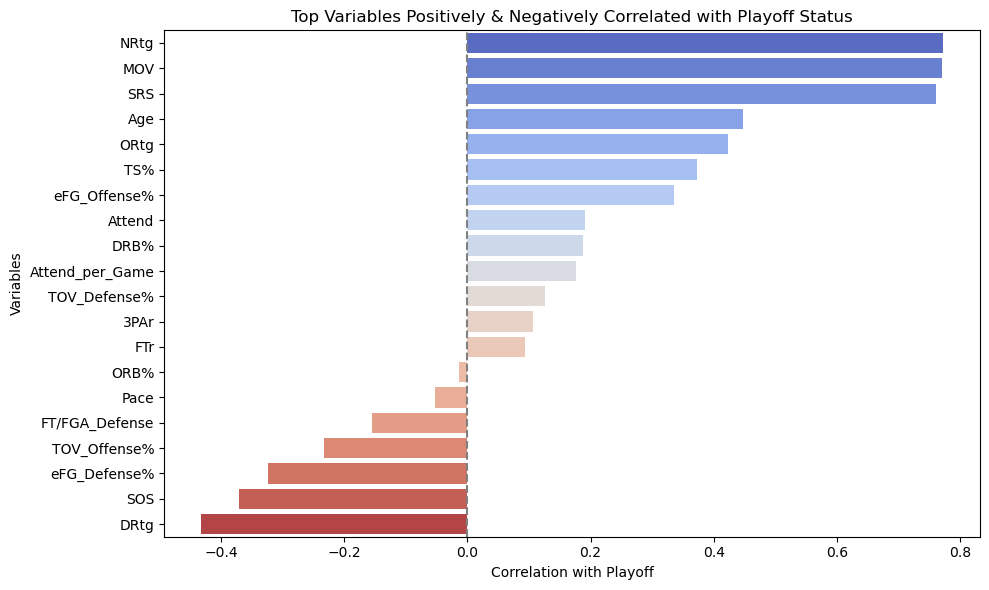

In [6]:
# Calculate correlation with 'Playoff', excluding itself, Rk, PW, PL, WinPct%, W, L
playoff_corr = df.corr(numeric_only = True)['Playoff'].drop(labels = ['Team', 'Arena', 'W', 'L', 'WinPct%', 'Year', 'Playoff', 'PW', 'PL', 'Rk'], errors = 'ignore')

# Sort values by strength of correlation
playoff_corr = playoff_corr.sort_values(ascending = False)

# Get top 10 positive and bottom 10 negative correlations
top_corr = playoff_corr.head(10)
bottom_corr = playoff_corr.tail(10)
both = pd.concat([top_corr, bottom_corr])

# Plot the results as a barplot
plt.figure(figsize = (10, 6))
sns.barplot(x = both.values, 
            y = both.index,
            hue = both.index, 
            legend = False, 
            palette = 'coolwarm')
plt.axvline(0, color = 'gray', linestyle = '--')
plt.title("Top Variables Positively & Negatively Correlated with Playoff Status")
plt.xlabel("Correlation with Playoff")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

#### What can we takeaway from the Correlation Bar Chart?

- `NRtg`,`MOV`,`SRS`, and `Age` all have a correlation coeffcient greater than 0.4, suggesting a strong positive correlation with playoff qualification. This indicates that teams with higher values in these variables are more likely to make the playoffs.
- `DRtg`,`SOS`,`eFG_Defense%`, and `TOV_Offense%` all have a correlation coeffcient less than -0.2, suggesting a negative correlation with playoff qualification. This indicates that teams with lower values in these variables are more likely to make the playoffs.
  - Logically, a team would want a lower value for these metrics `DRtg`,`eFG_Defense%`, and `TOV_Offense%` so this negative relationship makes sense. And of course, a lesser strength of schedule would lead one to believe that they are playing weaker teams and therefore probably have a better chance of winning. 

### Step 4: Logistic Regression (3 Methods)

In this section, we’ll build and compare three versions of logistic regression to predict whether an NBA team makes the playoffs based on regular-season statistics.

#### Methods:
1. **From-Scratch (No Optimization)**  
   We use randomly initialized weights and apply the sigmoid function to get predictions. This acts as a basic baseline for comparison, but doesn't involve any learning.

2. **Gradient Descent**  
   Using the gradients of the log-likelihood, we optimize the model parameters over multiple iterations. This mimics the logistic regression techniques we learned in class.

3. **Scikit-Learn Logistic Regression**  
   This is the standard library. We'll use it as a benchmark to confirm the performance of the other models.

We'll compare the accuracy of all three approaches. 

### Step 4a: Logistic Regression (From-Scratch - No Optimitization)

In [7]:
# Exclude columns that we don't want to include within out model, and then set up X and y
exclude_cols = ['Team', 'Arena', 'W', 'L', 'WinPct%', 'Year', 'Playoff', 'PW', 'PL', 'Rk']
X = df.drop(columns = [col for col in exclude_cols if col in df.columns]).dropna()
y = df.loc[X.index, 'Playoff'].values

# Scale X - center and spread out so that larger variables don't dominate
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create the sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Create the random weights and predictions - if we just guessed randomly how good would we be? 
np.random.seed(0)
weights = np.random.randn(X_scaled.shape[1])
bias = 0

# Calculate the linear combination
z = np.dot(X_scaled, weights) + bias
probs = sigmoid(z)
preds = (probs >= 0.5).astype(int)

# Evaluate the accuracy
accuracy_scratch = np.mean(preds == y)
print(f"From-Scratch Accuracy (No Training): {accuracy_scratch:.2f}")

From-Scratch Accuracy (No Training): 0.80


### Step 4b: Logistic Regression (Gradient Descent)

In [8]:
# Reset the weights and bias
np.random.seed(0)
weights = np.random.randn(X_scaled.shape[1])
bias = 0.0

# Create the training parameters
learning_rate = 0.1
n_iterations = 1000
losses = []

n = X_scaled.shape[0]

for i in range(n_iterations):
    z = np.dot(X_scaled, weights) + bias
    predictions = sigmoid(z)

    errors = predictions - y

    grad_w = np.dot(X_scaled.T, errors) / n
    grad_b = np.sum(errors) / n

    weights -= (learning_rate * grad_w)
    bias -= (learning_rate * grad_b)

    #Create and keep track of the loss for the gradient descent loss curve
    epsilon = 1e-15
    loss_predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.mean(y * np.log(loss_predictions) + (1 - y) * np.log(1 - loss_predictions))
    losses.append(loss)

# Create the final predictions
final_probs = sigmoid(np.dot(X_scaled, weights) + bias)
final_preds = (final_probs >= 0.5).astype(int)
accuracy_gradient = np.mean(final_preds == y)
print(f"Gradient Descent Accuracy: {accuracy_gradient:.2f}")

Gradient Descent Accuracy: 0.92


### Step 4b: Logisitic Regression (Gradient Descent) - Loss Curve

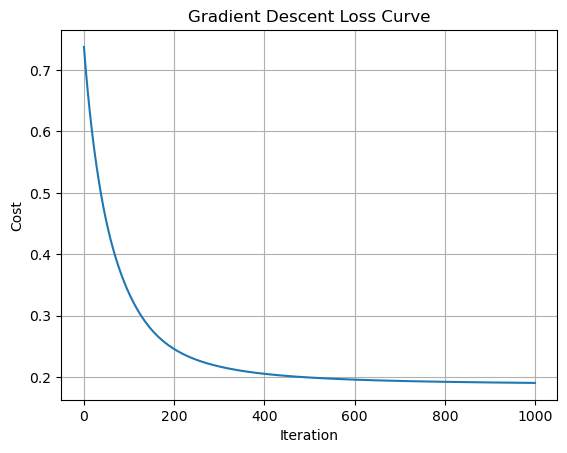

In [9]:
plt.plot(losses)
plt.title('Gradient Descent Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

#### What can we takeaway from the Gradient Descent Loss Curve? 

- The steep drop early indicates that the model is learning quickly.
- The curve starts to flatten around the ~600 iterations mark, indicating that we could probably lower the number of iterations without compromising too much on the accuracy. 

### Step 4c: Logistic Regression (Scikit-Learn Model)

In [10]:
# Split the data into training and testing subsets. 70% to training and 30% to testing. 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Train the model
sk_log_reg = LogisticRegression()
sk_log_reg.fit(X_train, y_train)

# Make the predictions
y_train_preds = sk_log_reg.predict(X_train)
y_test_preds = sk_log_reg.predict(X_test)

# Evaluate the accuracy
train_accuracy = accuracy_score(y_train, y_train_preds)
test_accuracy = accuracy_score(y_test, y_test_preds)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.93
Test Accuracy: 0.91


### Step 4c: Logisitic Regression Variable Importance (Scikit-Learn Model)

In [11]:
# Extract the coefficients
coefficients = sk_log_reg.coef_[0]
variables = X.columns

# Build the dataframe
coef_df = pd.DataFrame({
    'Variable': variables,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)})

# Grab the top 10 most influential variables (using the absolute value coeffcient) as a table
top_variables = coef_df.sort_values('AbsCoefficient', ascending = False).head(10)

# Create the Impact column to determine if the coefficient is positive or negative
top_variables['Impact'] = top_variables['Coefficient'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')

# Select the relevant columns to include
top_variables_final = top_variables[['Variable', 'Coefficient', 'Impact']]

# Print the table
print(top_variables_final.reset_index(drop=True))

         Variable  Coefficient    Impact
0            NRtg     1.332980  Positive
1             MOV     1.291237  Positive
2             SRS     1.249244  Positive
3             SOS    -0.850020  Negative
4            DRtg    -0.831037  Negative
5            ORtg     0.650404  Positive
6             TS%     0.610714  Positive
7    TOV_Defense%     0.606344  Positive
8    eFG_Defense%    -0.582842  Negative
9  FT/FGA_Offense     0.516341  Positive


### Step 4c: Evaluating Predictions with a Confusion Matrix (Scikit-Learn Model)

To better understand how our Scikit-Learn Model is performing, beyond just overall accuracy, we can look at a **confusion matrix**.

This matrix breaks down the model's predictions into four categories:

- **True Positives (TP)**: Teams that made the playoffs and were correctly predicted to do so. (Bottom Right)
- **False Positives (FP)**: Teams that did **not** make the playoffs but were incorrectly predicted as playoff teams. (Bottom Left)
- **True Negatives (TN)**: Teams that missed the playoffs and were correctly predicted as non-playoff teams. (Top Left)
- **False Negatives (FN)**: Teams that made the playoffs but were incorrectly predicted to miss them. (Top Right)

This breakdown helps us evaluate:
- Whether the model is more prone to over-predicting playoff teams (many FPs)
- Or more conservative and likely to miss some actual playoff teams (many FNs)


<Figure size 600x600 with 0 Axes>

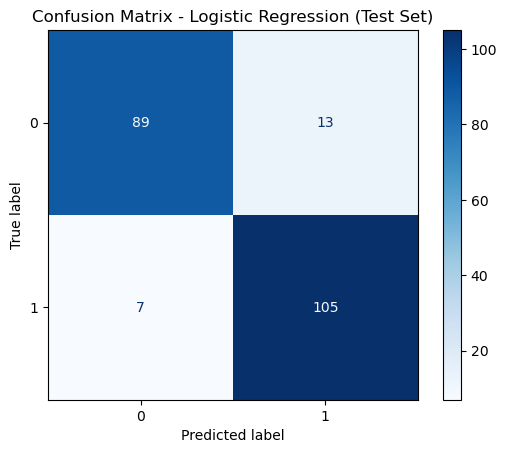

In [12]:
cm = confusion_matrix(y_test, y_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize = (6, 6))
disp.plot(cmap = 'Blues')
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.grid(False)
plt.show()

#### What can we takeaway from the Confusion Matrix? 

- 105 True Positives, 89 True Negatives, 7 False Positives, and 13 False Negatives.
- This indicates that the model performs well overall, with relatively few mistakes, and achieves a balanced ability to correctly identify both playoff and non-playoff teams.

### Step 4d: Logistic Regression (3 Method Comparisons)

In [13]:
# Side-by-side comparison
print("Model Accuracy Comparison:")
print(f"From Scratch Random Weights Accuracy:                {accuracy_scratch:.2f}")
print(f"Manual Gradient Descent Logistic Regression Accuracy: {accuracy_gradient:.2f}")
print(f"Scikit-learn Logistic Regression Test Accuracy:      {test_accuracy:.2f}")

Model Accuracy Comparison:
From Scratch Random Weights Accuracy:                0.80
Manual Gradient Descent Logistic Regression Accuracy: 0.92
Scikit-learn Logistic Regression Test Accuracy:      0.91


### Step 5: Conclusion

Over the course of this analysis, we explored whether regular-season team statistics could be used to predict playoff status, and how different modeling techniques and unsupervised learning strategies can be applied to this problem.

#### Key Findings
- **Correlation Analysis** showed that certain stats like,`MOV`,`NRtg`,`SRS` and `WinPct%`, have strong positive relationships with playoff qualification while `SOS`, `DRtg`, and `eFG%_Defense` have a strong negtiave relationships with playoff qualification. 
- **Logistic Regression** proved to be an effective technique in classifying playoff vs. non-playoff teams:
  - The **from-scratch no optimization model** gave us a baseline for comparison utilizing random weights and predictions.
  - The **gradient descent model** achieved ~92% accuracy, showing a solid handle of logistic regression fundamentals.
  - The **scikit-learn model** performed similarly with ~91-93% accuracy.
- **Top Influential Variables** revealed that both offensive and defensive varibles were major drivers of playoff qualification.

#### Limitations
- We used data from the entire regular season, so these models could not be used for real-time prediction.
- The labels for `Playoff` were binary, but there are even ranking to making the playoffs (i.e. 1st seed vs. 8th seed).

#### Future Work
- Explore multi-class classification to predict how far a team goes (e.g., first round, finals).
- Test these models using early-season or mid-season stats to simulate real-world playoff predictions.
- Utilize One Hot Encoding for the categorical variables rather than excluding them. 

#### Final Thoughts
This project demonstrated how basic and advanced analytics techniques, when combined with real-world sports data, can uncover meaningful insights, make reliable predictions, and build your intuition for how machine learning models interpret and interact with data.